In [1]:
# импортируем необходимые библиотеки
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from scipy.optimize import minimize
from arch import arch_model 
from copulae import ClaytonCopula, GaussianCopula, StudentCopula, FrankCopula, GumbelCopula

import warnings
warnings.filterwarnings("ignore")

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# загружаем данные за 5 лет
data = yf.download("AAPL HSBC TM MSFT AMZN", start="2017-01-01", end="2022-01-01", group_by="ticker")

data.head()

[*********************100%***********************]  5 of 5 completed


MSFT                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2017-01-03  62.790001  62.840000  62.130001  62.580002  57.501343  20694100   
2017-01-04  62.480000  62.750000  62.119999  62.299999  57.244072  21340000   
2017-01-05  62.189999  62.660000  62.029999  62.299999  57.244072  24876000   
2017-01-06  62.299999  63.150002  62.040001  62.840000  57.740242  19922900   
2017-01-09  62.759998  63.080002  62.540001  62.639999  57.556484  20382700   

                 AMZN                                   ...       AAPL  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2017-01-03  37.896000  37.938000  37.384998  37.683498  ...  28.690001   
2017-01-04  37.919498  37.984001  37.709999  37.859001  ...  28.937500   
2017-01-05  38.077499  39.119999  38.013000  39.022499  ...  28.952499   
2017-01-06  39.118000  39.972000  38.924000  39.799500  ...  29.117500   
2017-01-09  39.900002  40.088501  39.588501  39.846001  ...  29.485001   

                                                  HSBC                        \
                Close  Adj Close     Volume       Open       High        Low   
Date                                                                           
2017-01-03  29.037500  27.133324  115127600  41.070000  41.080002  40.740002   
2017-01-04  29.004999  27.102955   84472400  41.009998  41.299999  40.840000   
2017-01-05  29.152500  27.240788   88774400  41.049999  41.209999  40.919998   
2017-01-06  29.477501  27.544472  127007600  41.049999  41.270000  41.040001   
2017-01-09  29.747499  27.796770  134247600  40.759998  40.790001  40.619999   

                                           
                Close  Adj Close   Volume  
Date                                       
2017-01-03  40.889999  29.868021  2353000  
2017-01-04  41.279999  30.152889  1398700  
2017-01-05  41.160000  30.065228  1573900  
2017-01-06  41.150002  30.057928  2313300  
2017-01-09  40.660000  29.700012  1896500  

[5 rows x 30 columns]

In [3]:
# извлекаем из данных цены акций на момент закрытия торгов
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

,AAPL,AMZN,HSBC,MSFT,TM
Date,,,,,
2017-01-03,29.037500,37.683498,40.889999,62.580002,118.550003
2017-01-04,29.004999,37.859001,41.279999,62.299999,121.190002
2017-01-05,29.152500,39.022499,41.160000,62.299999,120.440002
2017-01-06,29.477501,39.799500,41.150002,62.840000,120.129997
2017-01-09,29.747499,39.846001,40.660000,62.639999,119.739998


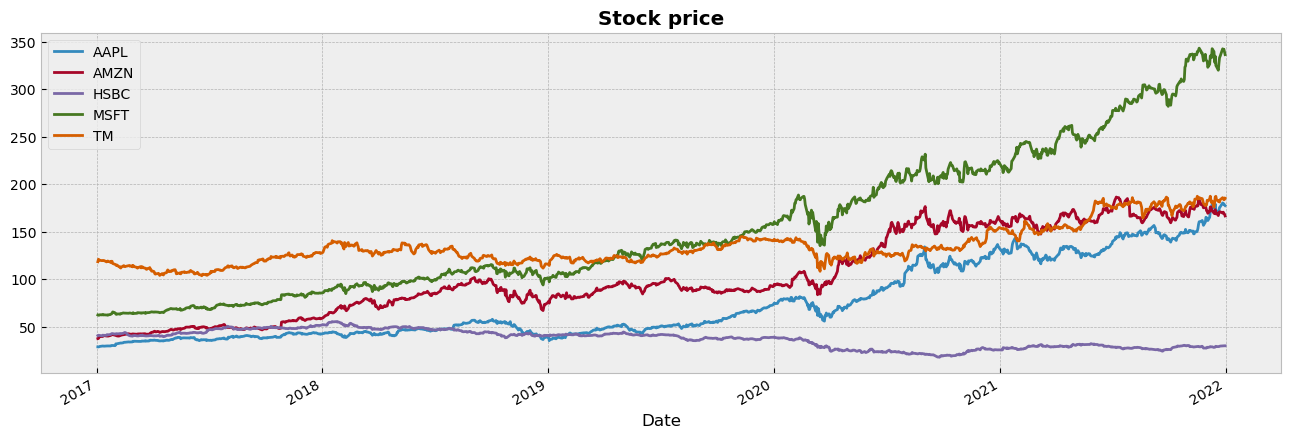

In [4]:
# строим график изменения цены каждой акции
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")
plt.show()

In [5]:
#выполняем предобработку данных
returns = 100 * prices.pct_change().dropna()
returns.head()

,AAPL,AMZN,HSBC,MSFT,TM
Date,,,,,
2017-01-04,-0.111928,0.465728,0.953777,-0.447431,2.226908
2017-01-05,0.508536,3.073240,-0.290695,0.000000,-0.618863
2017-01-06,1.114830,1.991160,-0.024291,0.866775,-0.257394
2017-01-09,0.915948,0.116839,-1.190770,-0.318270,-0.324648
2017-01-10,0.100851,-0.127999,0.221348,-0.031929,0.016706


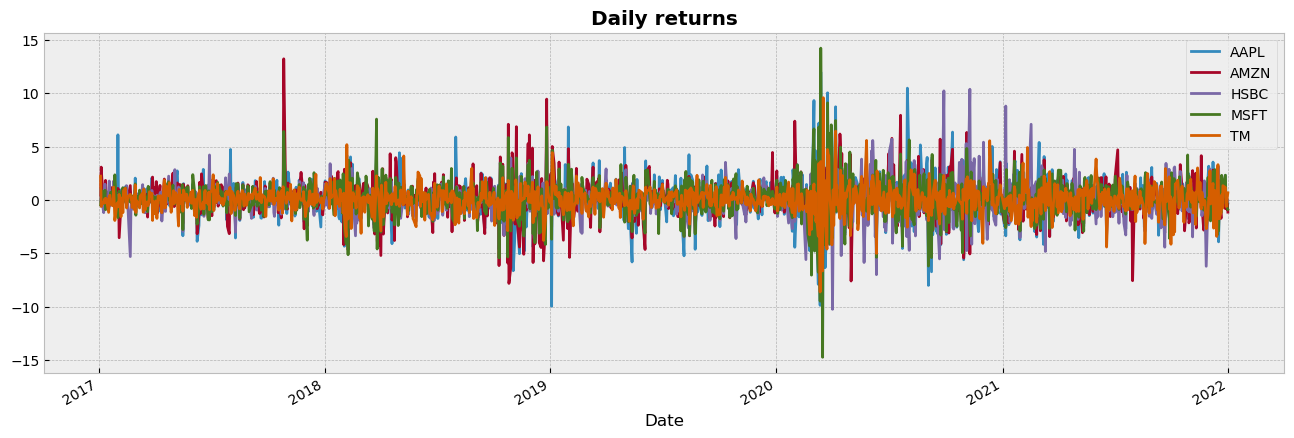

In [6]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")
plt.show()

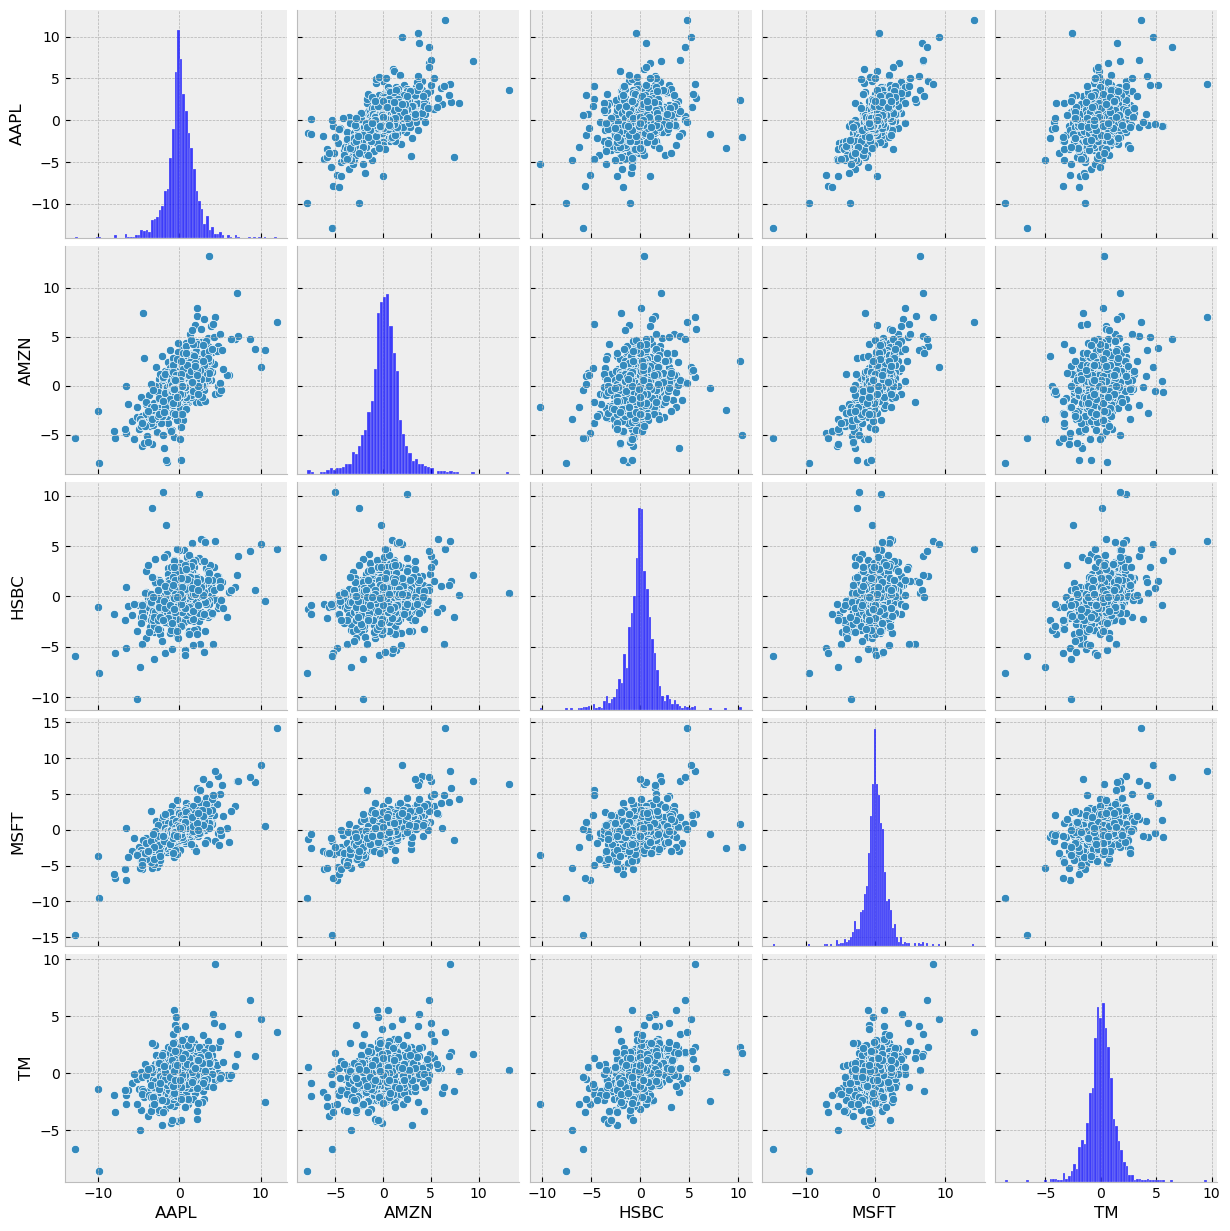

In [7]:
# построим графики распределения
sns.pairplot(returns)
plt.show()

In [8]:
# при помощи данной функции перебора параметров найдём идеальное количество лагов в arch_model
def best_lags(ret, dist):
    
    scaling_const = 10.0 / ret.std()
    
    best_p, best_o, best_q, best_lags = 0, 0, 0, 0
    best_aic = np.inf
    
    for p in range(0,4):
        for o in range(0,4):
            for q in range(0,4):
                for lags in range(0,11):
                    try:
                        # объявляем GARCH модель
                        am = arch_model(ret * scaling_const,
                                        mean='HARX', lags=lags, # mean = Constant, ARX, HARX + the number of lags
                                        vol='Garch', p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                                        dist=dist) # dist = Normal, t, skewstudent, ged

                        # фитим модель на данных
                        res = am.fit(update_freq=0, disp='off')
    
                        # сохраняем наилучшую модель
                        if res.aic < best_aic:
                            best_aic = res.aic
                            best_p, best_o, best_q, best_lags = p, o, q, lags
                    except:
                        pass
    return best_p, best_o, best_q, best_lags

In [9]:
# запустим функцию подбора параметров для портфеля
best_lags(returns['AAPL'] + returns['AMZN'] + returns['HSBC'] + returns['MSFT'] + returns['TM'], dist='skewstudent')

(0, 1, 1, 10)

In [10]:
# функции для дальнейших вычислений, где можно задавать значения p,o,q
def get_garch_residuals(ret, dist, p, o, q, lags):
    
    scaling_const = 10.0 / ret.std()
                    
    # сохраняем параметры лучшей модели
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=lags, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged
    
    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid, res.params[-2:])
   
    return cdf, am, res, scaling_const

def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent',p=1,o=0,q=1,lags=1):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const= get_garch_residuals(returns[col], dist, p, o, q, lags)
            distribution_params[col] = (am, res)
            cdfs[col] = cdf


    # фитим копулу
    cop.fit(cdfs[1:])

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [11]:
%%capture
alpha = 0.1
ret = returns.dropna()

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500

VaR_curve_copula_gauss = []
VaR_curve_copula_student = []
VaR_curve_copula_clayton = []
VaR_curve_copula_frank = []
VaR_curve_copula_gumbel = []

# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    copula_gauss = make_copula_simulation(current_estimation_sample, GaussianCopula, n_samples=10**4, univariate_dist='garch', p=0, o=1, q=1, lags=10)
    VaR_curve_copula_gauss.append(np.quantile(np.dot(copula_gauss.values, w), alpha))
    
    copula_student = make_copula_simulation(current_estimation_sample, StudentCopula, n_samples=10**4, univariate_dist='garch', p=0, o=1, q=1, lags=10)
    VaR_curve_copula_student.append(np.quantile(np.dot(copula_student.values, w), alpha))
    
    copula_clayton = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='garch', p=0, o=1, q=1, lags=10)
    VaR_curve_copula_clayton.append(np.quantile(np.dot(copula_clayton.values, w), alpha))
    
    copula_frank = make_copula_simulation(current_estimation_sample, FrankCopula, n_samples=10**4, univariate_dist='garch', p=0, o=1, q=1, lags=10)
    VaR_curve_copula_frank.append(np.quantile(np.dot(copula_frank.values, w), alpha))
    
    copula_gumbel = make_copula_simulation(current_estimation_sample, GumbelCopula, n_samples=10**4, univariate_dist='garch', p=0, o=1, q=1, lags=10)
    VaR_curve_copula_gumbel.append(np.quantile(np.dot(copula_gumbel.values, w), alpha))
    
VaR_curve_copula_gauss = pd.Series(VaR_curve_copula_gauss, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_student = pd.Series(VaR_curve_copula_student, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_clayton = pd.Series(VaR_curve_copula_clayton, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_frank = pd.Series(VaR_curve_copula_frank, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_gumbel = pd.Series(VaR_curve_copula_gumbel, index=ret[estimation_window+T_start:].index)

portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

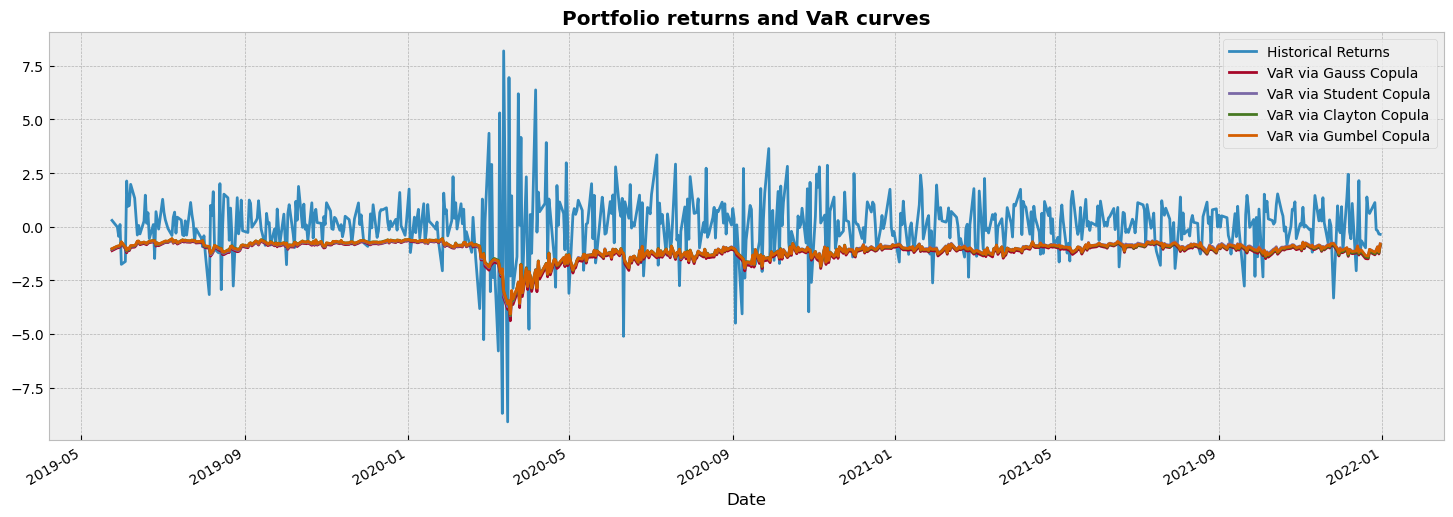

In [21]:
#построим графики. frank закомментируем для наглядности остальных графиков

fig = plt.figure()
fig.set_size_inches(18,6)
portfolio.plot()
VaR_curve_copula_gauss.plot()
VaR_curve_copula_student.plot()
VaR_curve_copula_clayton.plot()
#VaR_curve_copula_frank.plot()
VaR_curve_copula_gumbel.plot()

plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Gauss Copula',
            'VaR via Student Copula',
            'VaR via Clayton Copula',
            #'VaR via Frank Copula',
            'VaR via Gumbel Copula'])
plt.show()

In [13]:
# функция для теста Купика
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

## Тест Купика

In [14]:
kupiec_test(VaR_curve_copula_gauss, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 10.0%
Уровень пробитий в модели: 12.46%

p-value теста: 0.042

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [15]:
kupiec_test(VaR_curve_copula_student, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 10.0%
Уровень пробитий в модели: 14.29%

p-value теста: 0.001

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [16]:
kupiec_test(VaR_curve_copula_clayton, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 10.0%
Уровень пробитий в модели: 14.13%

p-value теста: 0.001

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [17]:
kupiec_test(VaR_curve_copula_frank, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 10.0%
Уровень пробитий в модели: 0.00%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [18]:
kupiec_test(VaR_curve_copula_gumbel, portfolio)

Количество наблюдений: 658
Желаемый уровень пробитий: 10.0%
Уровень пробитий в модели: 14.59%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


По результатам теста Купика можно сделать вывод о том, что наилучшей для нас моделью будет VaR_curve_copula_gauss (копула Гаусса) из-за наилучших результатов при бэктестировании. Уровень пробитий наиболее близок к желаемому и значение p_value наибольшее.

Функция для подбора веса портфеля таким образом, чтобы минимизировать риск (то есть Value-at-Risk)

In [19]:
# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    # при помощи данного дополнения можно подбирать веса портфеля по показателю Expected Success/Shortfall Ratio
    elif objective_type == 'esr':
        threshold = np.quantile(portfolio_simulation, alpha)
        expected_success = np.mean(portfolio_simulation[portfolio_simulation >= threshold])
        expected_shortfall = np.mean(threshold - portfolio_simulation[portfolio_simulation < threshold])
        return -expected_success / expected_shortfall
    
def optimize(returns_simulation, alpha=0.1, objective_type='esr'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

In [22]:
# запустим код с подбором весов для наилучшей модели (по результатам бэктеста), а также с return и var

alpha = 0.1

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_esr = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_gauss, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_gauss, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
    w_opt = optimize(copula_gauss, objective_type='esr')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_esr.append(value_new)
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_var.pop(0)
value_opt_weights_esr.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
value_opt_weights_esr = pd.Series(value_opt_weights_esr, index=ret[estimation_window+T_start:].index)

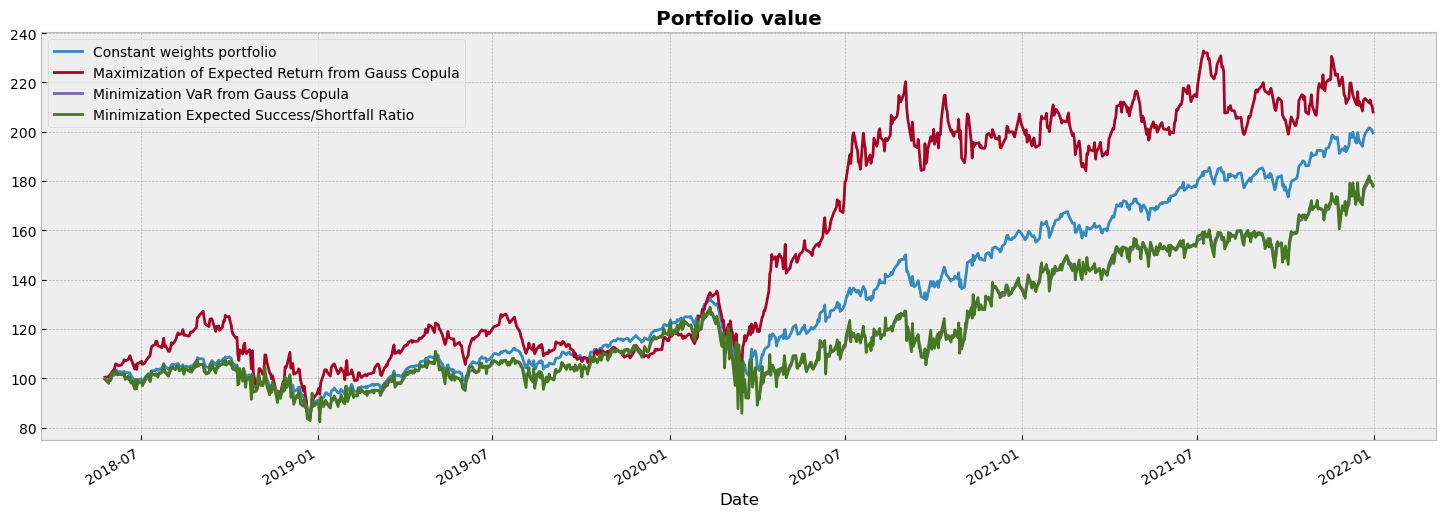

In [23]:
# Построим график изменения стоимости нашего портфеля
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_var.plot()
value_opt_weights_esr.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from Gauss Copula',
            'Minimization VaR from Gauss Copula',
            'Minimization Expected Success/Shortfall Ratio'])
plt.show()